### Load Detections from Alerce ZTF2 Database

In [75]:
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy.units import deg
import os
from datetime import date
import time
from collections import Counter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

# Libraries for getting Alerce data out of ZTF2 database
import json
import psycopg2
from alerce.api import AlerceAPI

# MSE imports
from utils import range_inc
from astro_utils import date_to_mjd, mjd_to_date
from ztf_data import load_ztf_det, load_ztf_det_year, ztf_det_add_dir
from ra_dec import radec2dir, radec_diff, direction_diff

In [76]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [2]:
# Load 2018 and 2019 data
df_2018 = load_ztf_det_year(2018)
df_2019 = load_ztf_det_year(2019)
df_2020 = load_ztf_det_year(2020)

Loaded ../data/ztf/ztf-detections-2018.h5 from disk.
Loaded ../data/ztf/ztf-detections-2019.h5 from disk.
Loaded ../data/ztf/ztf-detections-2020.h5 from disk.


In [3]:
# Combine frames into one DataFrame
df = pd.concat([df_2018, df_2019, df_2020])
df

,ObjectID,CandidateID,mjd,ra,dec,asteroid_prob
0,b'ZTF18aahbsho',518255634615010004,58272.255637,247.480690,34.027481,0.998269
1,b'ZTF18aaxpmnp',517454781815010004,58271.454780,308.738474,32.164302,0.935730
2,b'ZTF18aaxjdey',517457175915015004,58271.457176,299.974765,28.940493,0.915364
3,b'ZTF18aawceqv',516377973215015007,58270.377974,302.335815,34.731209,0.686181
4,b'ZTF18aawceqv',516434764515015021,58270.434768,302.335813,34.731214,0.686181
...,...,...,...,...,...,...
17265,b'ZTF20aarbpjv',1151110874715015000,58905.110880,30.868254,5.255209,1.000000
17266,b'ZTF20aarbple',1151111784015015003,58905.111782,29.698298,20.444825,1.000000
17267,b'ZTF20aarbpli',1151111783215015001,58905.111782,33.721698,20.553823,1.000000
17268,b'ZTF20aarbpmt',1151111784315015004,58905.111782,29.737316,19.527889,1.000000


In [4]:
df.dtypes

ObjectID            |S12
CandidateID        int64
mjd              float64
ra               float64
dec              float64
asteroid_prob    float64
dtype: object

In [42]:
# Extract the year-month tuple for each observation for summarizing
tt = Time(df.mjd, format='mjd')
isotimes = tt.iso
ym = np.array([isotime[0:7] for isotime in isotimes])
ym_ser = pd.Series(data=ym, index=df.index)

In [73]:
obs_monthly = df.groupby(ym_ser)
obs_monthly_count = obs_monthly.size()
obs_monthly_count

2018-06     11857
2018-07     20247
2018-08     29679
2018-09     44454
2018-10      1883
2018-11     27826
2018-12     13600
2019-01     13909
2019-02      3830
2019-03      4583
2019-04     12679
2019-05     14132
2019-06     32448
2019-07    276228
2019-08    847913
2019-09    658618
2019-10    831872
2019-11    789536
2019-12    355139
2020-01    961771
2020-02    745758
dtype: int64

In [80]:
obs_monthly_count.index.values

array(['2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11',
       '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05',
       '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
       '2019-12', '2020-01', '2020-02'], dtype=object)

In [102]:
x = month_strs[5]
x
# date(int(x[0:4]), int(x[5:7]), 1)

'2018-11'

In [104]:
month_strs = obs_monthly_count.index.values
x_dates = [date(int(x[0:4]), int(x[5:7]), 1) for x in month_strs]
x_dates

[datetime.date(2018, 6, 1),
 datetime.date(2018, 7, 1),
 datetime.date(2018, 8, 1),
 datetime.date(2018, 9, 1),
 datetime.date(2018, 10, 1),
 datetime.date(2018, 11, 1),
 datetime.date(2018, 12, 1),
 datetime.date(2019, 1, 1),
 datetime.date(2019, 2, 1),
 datetime.date(2019, 3, 1),
 datetime.date(2019, 4, 1),
 datetime.date(2019, 5, 1),
 datetime.date(2019, 6, 1),
 datetime.date(2019, 7, 1),
 datetime.date(2019, 8, 1),
 datetime.date(2019, 9, 1),
 datetime.date(2019, 10, 1),
 datetime.date(2019, 11, 1),
 datetime.date(2019, 12, 1),
 datetime.date(2020, 1, 1),
 datetime.date(2020, 2, 1)]

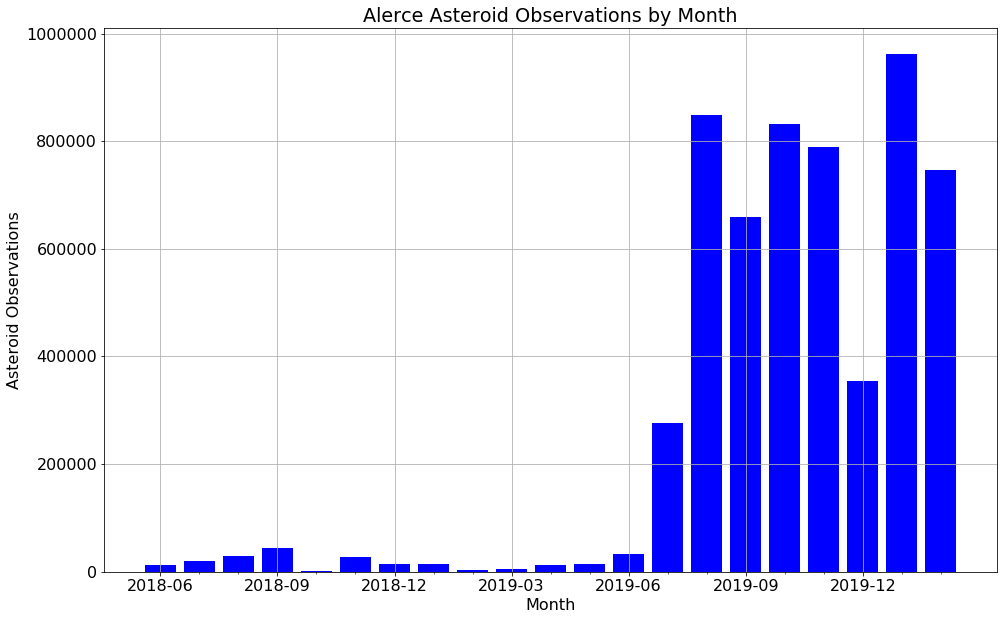

In [120]:
# Calculations for plot
month_strs = obs_monthly_count.index.values
x_values = np.arange(obs_monthly_count.size)
x_dates = [date(int(x[0:4]), int(x[5:7]), 1) for x in month_strs]
y_values = obs_monthly_count.values

# Plot the number of observations by month
fig, ax = plt.subplots()
ax.set_title('Alerce Asteroid Observations by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Asteroid Observations')
# ax.bar(x=x_values, height=y_values, tick_label=month_strs, color='blue')
ax.bar(x=x_values, height=y_values, color='blue')
ax.set_xticks(x_values[::3])
ax.set_xticks(x_values, minor=True)
ax.set_xticklabels(month_strs[::3], minor=False)
# ax.legend()
ax.grid()
# fig.savefig('alerce_ast_per_month.png', bbox_inches='tight')
plt.show()

In [121]:
# Extract mjd, ra, and dec as vectors of astropy angles
mjd = df.mjd.values
ra = df.ra.values * deg
dec = df.dec.values * deg

In [123]:
# Add the direction to the combined Alerce DataFrame using radec2dir()
u = radec2dir(ra=ra, dec=dec, obstime_mjd=mjd)

In [124]:
u.shape

(3, 5697962)

In [ ]:
# Add these directions to the DataFrame
df.insert(loc=5, column='ux', value=0.0)
df.insert(loc=6, column='uy', value=0.0)
df.insert(loc=7, column='uz', value=0.0)
df

In [ ]:
# Save computed directions to DataFrame
df.ux = u_ztf[0]
df.uy = u_ztf[1]
df.uz = u_ztf[2]

In [ ]:
file_name='../data/ztf/ztf-detections.h5'
df.to_hdf(file_name, key='df', mode='w')

In [ ]:
ztf_det_add_dir(df=df, file_name='ztf-detections.h5', dir_name='../data/ztf')

In [ ]:
df = pd.read_hdf('../data/ztf/ztf-detections.h5')

In [ ]:
df.dtypes